In [3]:
from src.agents import NotesAgent

In [4]:
from ax import (
    SearchSpace,
    ParameterType,
    ChoiceParameter,
    OptimizationConfig,
    Runner,
    Experiment,
    Objective,
)


import json
from src.agents import NotesAgent, KGAgent, MilvusAgent
from src.agents.notes_agent import BaseNotesResponse

from pydantic import Field
from typing import List
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType
from src.config import Config

config = Config()

In [5]:
# ---------------------------------- load exp config ----------------------------------
exp_config_path = "/Users/little1d/Desktop/Code/Faithful-BO/src/config/direct_arylation_new_config.json"
result_dir = "/Users/little1d/Desktop/Code/Faithful-BO/data/notes_result"

with open(exp_config_path, "r") as f:
    da_config = json.load(f)
da_config

{'name': 'Direct Arylation Reaction Optimization',
 'application_context': 'Chemistry/Reaction Condition Optimization',
 'description': 'This experiment aims to optimize the direct arylation reaction by exploring combinations of base, ligand, solvent, concentration, and temperature to maximize reaction yield or desired product selectivity. The input parameters include categorical choices of reactants and solvents, discrete temperature levels, and predefined concentration points. The goal is to identify the best reaction conditions within chemically feasible space.',
 'constraint': 'All selected SMILES strings must correspond to compatible chemical components. Temperature and concentration values must be among experimentally supported points.',
 'parameter_definitions': [{'display_name': 'Base_SMILES',
   'description': 'SMILES string representing the base and counterion used in the reaction.',
   'data_type': 'categorical',
   'bounds': ['O=C([O-])C(C)(C)C.[Cs+]',
    'O=C([O-])C(C)(C)

In [6]:
# ---------------------------------- Defining custom metric and Notes response ----------------------------------
from typing import Dict


class ExperimentInfoResponse(BaseNotesResponse):
    """Response template for detailed experiment information extraction"""

    reaction_name: str = Field(
        ..., description="Name of the chemical reaction"
    )
    reaction_domain: str = Field(
        ..., description="Chemical domain of the reaction"
    )
    reaction_description: str = Field(
        ..., description="Detailed description of the reaction purpose"
    )
    constraints: List[str] = Field(
        ..., description="Experimental constraints and requirements"
    )
    reactants: List[Dict] = Field(
        ..., description="List of reactants with SMILES and properties"
    )
    conditions: Dict = Field(
        ..., description="Detailed reaction conditions including ranges"
    )
    target: Dict = Field(
        ..., description="Optimization target with description"
    )
    chemical_relationships: List[str] = Field(
        ..., description="Relationships between chemical components"
    )
    theoretical_background: List[str] = Field(
        default_factory=list,
        description="Key theoretical concepts relevant to this reaction",
    )


class ReasoningNotesResponse(BaseNotesResponse):
    """Response format for extracting experiment knowledge from reasoning data"""

    key_findings: List[str] = Field(
        ..., description="Important experimental findings and observations"
    )
    chemical_insights: List[str] = Field(
        ..., description="Chemical insights about the reaction system"
    )
    parameter_relationships: List[str] = Field(
        ...,
        description="Relationships between different experimental parameters",
    )
    optimization_strategies: List[str] = Field(
        ..., description="Suggested optimization approaches"
    )
    theoretical_principles: List[str] = Field(
        ..., description="Underlying chemical principles involved"
    )
    potential_issues: List[str] = Field(
        default_factory=list,
        description="Potential problems or challenges identified",
    )


extract_notes_prompt = """
    Analyze this reasoning data and extract key experiment-related knowledge:
    1. Important findings and observations
    2. Chemical insights about the reaction system
    3. Relationships between different parameters
    4. Suggested optimization strategies
    5. Underlying theoretical principles
    6. Potential issues or challenges
    
    Return structured JSON matching the provided schema.
    Reasoning data: {input}
    """

from src.tasks import ChemistryMetric

In [7]:
# ---------------------------------- Creat Search Space ----------------------------------
parameters = [
    ChoiceParameter(
        name="Base_SMILES",
        parameter_type=ParameterType.STRING,
        values=[
            "O=C([O-])C(C)(C)C.[Cs+]",
            "O=C([O-])C(C)(C)C.[K+]",
            "O=C([O-])C.[Cs+]",
            "O=C([O-])C.[K+]",
        ],
    ),
    ChoiceParameter(
        name="Ligand_SMILES",
        parameter_type=ParameterType.STRING,
        values=[
            "C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@]3(C)C1",
            "CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C",
            "CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC)=CC=C2OC",
            "CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C)=CC(C(C)C)=C1)C",
            "CC(OC1=C(P(C2CCCCC2)C3CCCCC3)C(OC(C)C)=CC=C1)C",
            "CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3",
            "CP(C)C1=CC=CC=C1",
            "CP(C1=CC=CC=C1)C2=CC=CC=C2",
            "FC(F)(F)C1=CC(P(C2=C(C3=C(C(C)C)C=C(C(C)C)C=C3C(C)C)C(OC)=CC=C2OC)C4=CC(C(F)(F)F)=CC(C(F)(F)F)=C4)=CC(C(F)(F)F)=C1",
            "P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3",
            "P(C1=CC=CO1)(C2=CC=CO2)C3=CC=CO3",
            "P(C1CCCCC1)(C2CCCCC2)C3CCCCC3",
        ],
    ),
    ChoiceParameter(
        name="Solvent_SMILES",
        parameter_type=ParameterType.STRING,
        values=[
            "CC(N(C)C)=O",
            "CC1=CC=C(C)C=C1",
            "CCCC#N",
            "CCCCOC(C)=O",
        ],
    ),
    ChoiceParameter(
        name="Concentration",
        parameter_type=ParameterType.FLOAT,
        values=[
            0.057,
            0.1,
            0.153,
        ],
    ),
    ChoiceParameter(
        name="Temp_C", parameter_type=ParameterType.INT, values=[90, 105, 120]
    ),
]

direct_arylation_search_space = SearchSpace(parameters=parameters)

/var/folders/xy/2nl06h6134z8d63822qpjs840000gn/T/ipykernel_10489/1632722945.py:3: AxParameterWarning: `is_ordered` is not specified for `ChoiceParameter` "Base_SMILES". Defaulting to `False`  since the parameter is a string with more than 2 choices.. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction. Note that choice parameters with exactly 2 choices are always considered ordered and that the user-supplied `is_ordered` has no effect in this particular case.
  ChoiceParameter(
/var/folders/xy/2nl06h6134z8d63822qpjs840000gn/T/ipykernel_10489/1632722945.py:3: AxParameterWarning: `sort_values` is not specified for `ChoiceParameter` "Base_SMILES". Defaulting to `False` for parameters of `ParameterType` STRING. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
  ChoiceParameter(
/var/folders/xy/2nl06h6134z8d63822qpjs840000gn/T/ipykernel_10489/1632722945.py:13: AxParameter

In [8]:
# ---------------------------------- Create Optimization Config ----------------------------------
from src.tasks.chemistry.chemistry import ChemistryProblemType

optimization_config = OptimizationConfig(
    objective=Objective(
        metric=ChemistryMetric(
            name="da_faith_bo",
            problem_type=ChemistryProblemType.DIRECT_ARYLATION,
        )
    )
)

In [9]:
# ---------------------------------- Define a Runner ----------------------------------
class DARunner(Runner):
    def run(self, trial):
        trial_metadata = {"name": str(trial.index)}
        return trial_metadata

In [10]:
# ---------------------------------- Create Experiment ----------------------------------

exp = Experiment(
    name="da_faithful_bo",
    search_space=direct_arylation_search_space,
    optimization_config=optimization_config,
    runner=DARunner(),
)

In [11]:
# ---------------------------------- Load Models and NotesAgent ----------------------------------
from src.bo.models import BOModel
from src.bo.reasoner.qwq import QWQReasoner

qwq_reasoner = QWQReasoner(
    exp_config_path=exp_config_path, result_dir=result_dir
)
bo_model = BOModel(exp)

deepseek = ModelFactory.create(
    model_platform=ModelPlatformType.DEEPSEEK,
    api_key=config.DEEPSEEK_API_KEY,
    url=config.DEEPSEEK_API_BASE,
    model_type=ModelType.DEEPSEEK_CHAT,
    model_config_dict={"max_tokens": 2048},
)

kg_agent = KGAgent(deepseek)
milvus_agent = MilvusAgent(collection_name="test")

notes_agent = NotesAgent(
    model=deepseek, kg_agent=kg_agent, milvus_agent=milvus_agent
)

qwq_client = qwq_reasoner.client

Error loading agent_prompts.json: Expecting value: line 1 column 1 (char 0)
Error loading llm_prompts.json: Expecting value: line 1 column 1 (char 0)


In [12]:
# ---------------------------------- 测试实验信息搜索与提取功能 ----------------------------------
experiment_prompt = """
Please extract comprehensive information from this experimental configuration for chemical reaction optimization:

1. Reaction Basics:
   - Name and domain of the reaction
   - Detailed purpose and description
   - Any experimental constraints

2. Chemical Components:
   - List all reactants with their SMILES and properties
   - Extract all possible bases, ligands, and solvents with their SMILES
   - Note any important chemical properties or characteristics

3. Reaction Conditions:
   - Temperature ranges and units
   - Concentration ranges and units
   - Other critical parameters

4. Optimization Target:
   - Target metric name and description
   - Theoretical maximum if available

5. Chemical Relationships:
   - How components interact (e.g., base-deprotonation, ligand-catalyst stabilization)
   - Known effects of condition variations

6. Theoretical Background:
   - Key mechanisms involved
   - Relevant chemical principles
   - Known challenges in this reaction type

Return structured information covering all these aspects. Ensure all SMILES strings are accurate.

Experimental Configuration:
{input}
"""

# 将实验配置(json)转为字符串
experiment_str = json.dumps(da_config, indent=2, ensure_ascii=False)

# 执行提取
print("=== 实验信息提取，并存储至数据库中 ===")
experiment_info = notes_agent.extract_experiment_info(
    experiment_data=experiment_str,
    save_schema=ExperimentInfoResponse,
    prompt=experiment_prompt,
)

=== 实验信息提取，并存储至数据库中 ===
2025-04-01 17:19:34,323 - camel.agents.chat_agent - ERROR - Failed in parsing the output into JSON: Expecting value: line 1 column 1 (char 0)
response content: msgs=[BaseMessage(role_name='Assistant', role_type=<RoleType.ASSISTANT: 'assistant'>, meta_dict={}, content='```json\n{\n  "notes": [],\n  "reaction_name": "Direct Arylation Reaction Optimization",\n  "reaction_domain": "Chemistry/Reaction Condition Optimization",\n  "reaction_description": "This experiment aims to optimize the direct arylation reaction by exploring combinations of base, ligand, solvent, concentration, and temperature to maximize reaction yield or desired product selectivity. The input parameters include categorical choices of reactants and solvents, discrete temperature levels, and predefined concentration points. The goal is to identify the best reaction conditions within chemically feasible space.",\n  "constraints": [\n    "All selected SMILES strings must correspond to compatible che

In [13]:
# ---------------------------------- 1. 生成 overview ----------------------------------
overview = qwq_reasoner.generate_overview()
print(overview)

Start generating overview...
Overview has been generated! and the content is as follows
 ### Overview of Direct Arylation Reaction Optimization Experiment

The primary objective of this experiment is to optimize the direct arylation reaction, a critical process in organic synthesis for coupling aryl halides with aryl or alkyl boronic esters. By fine-tuning reaction conditions such as the choice of base, ligand, solvent, concentration, and temperature, we aim to maximize the yield of the desired product while minimizing byproducts and side reactions. This optimization is crucial for enhancing synthetic efficiency and reducing waste in industrial processes, thereby contributing significantly to sustainable chemistry practices.

The parameter space for this experiment encompasses five key dimensions: Base_SMILES, Ligand_SMILES, Solvent_SMILES, Concentration, and Temp_C. Each parameter has distinct categorical bounds, ensuring that only chemically compatible and experimentally validated op

In [14]:
# 2. 初始采样
insight_first_round = qwq_reasoner.initial_sampling()

Start initial sampling...
Initial sampling process has done! and the insight is as follows
 ```json
{
  "comment": "This initial sampling strategy aims to explore a diverse set of reaction conditions by selecting combinations of bases, ligands, solvents, concentrations, and temperatures that are chemically plausible and have not been extensively explored. Each hypothesis is designed to cover a broad spectrum of possibilities to maximize the likelihood of identifying optimal reaction conditions.",
  "keywords": "Chemistry, Reaction Condition Optimization, Direct Arylation, Initial Sampling",
  "hypotheses": [
    {
      "strategy": "Diverse Base and Ligand Exploration",
      "rationale": "Selecting a broad range of bases and ligands to ensure comprehensive coverage of potential reactivity.",
      "confidence": "high",
      "parameter_sets": [
        {
          "Base_SMILES": "O=C([O-])C(C)(C)C.[Cs+]",
          "Ligand_SMILES": "C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@]3(C)C

In [15]:
# 3. 第一轮实验
candidates_array = qwq_reasoner.optimization_first_round(insight_first_round)
# reasoning data从 qwq_client.messages 里面拿
for msg in qwq_client.messages:
    if msg.get("role") == "think":
        reasoning_data = msg.get("content")
knowledge = notes_agent.extract_notes(
    reasoning_data=reasoning_data,
    save_schema=ReasoningNotesResponse,
    prompt=extract_notes_prompt,
)
print(f"Extracted Notes from reasoning data:{knowledge}")

trial = qwq_reasoner.run_bo_experiment(exp, candidates_array)
qwq_reasoner._save_experiment_data(exp, trial)

Start extracting candidates array from insight...
Done! We have collected 5 candidates, The candidates points is as follows[{'Base_SMILES': 'O=C([O-])C(C)(C)C.[Cs+]', 'Ligand_SMILES': 'C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@]3(C)C1', 'Solvent_SMILES': 'CC(N(C)C)=O', 'Concentration': 0.1, 'Temp_C': 105}, {'Base_SMILES': 'O=C([O-])C(C)(C)C.[Cs+]', 'Ligand_SMILES': 'CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C', 'Solvent_SMILES': 'CC1=CC=C(C)C=C1', 'Concentration': 0.057, 'Temp_C': 90}, {'Base_SMILES': 'P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3', 'Ligand_SMILES': 'P(C1=CC=CO1)(C2=CC=CO2)C3=CC=CO3', 'Solvent_SMILES': 'CC1=CC=C(C)C=C1', 'Concentration': 0.1, 'Temp_C': 105}, {'Base_SMILES': 'P(C1CCCCC1)(C2CCCCC2)C3CCCCC3', 'Ligand_SMILES': 'P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3', 'Solvent_SMILES': 'CCCC#N', 'Concentration': 0.057, 'Temp_C': 90}, {'Base_SMILES': 'O=C([O-])C.[Cs+]', 'Ligand_SMILES': 'CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC)=CC=C2OC', 'Solvent_SMILES': 'CCCC#N', 'C

In [16]:
# 4. 多轮优化循环
num_iterations = 2  # 设置迭代次数
for i in range(num_iterations):
    # 检索的时候要在 insight 中加入 key_word 键，用 key_word 去 query 知识库，放在 optimization_loop 函数中
    # 如果不想启用混合检索，只需要不传 retrieved_context 或置空
    keywords = qwq_reasoner.get_keywords()
    print(f"Keywords:{keywords}")
    retrieved_context = ''
    if keywords:
        results = notes_agent.query_notes(
            query=keywords, top_k=3, similarity_threshold=0.7
        )
        retrieved_context = notes_agent.format_retrieved_notes(results)
    print(f"retrieved context: \n{retrieved_context}")
    candidates_array = qwq_reasoner.optimization_loop(
        experiment=exp,
        trial=trial,
        bo_model=bo_model,
        n=5,
        retrieval_context=retrieved_context,
    )
    # 在这里再从 qwq_client.messages 中拿到 reasoning data 并存储
    for msg in qwq_client.messages:
        if msg.get("role") == "think":
            reasoning_data = msg.get("content")
    knowledge = notes_agent.extract_notes(
        reasoning_data=reasoning_data,
        save_schema=ReasoningNotesResponse,
        prompt=extract_notes_prompt,
    )
    trial = qwq_reasoner.run_bo_experiment(exp, candidates_array)

Keywords:Chemistry, Reaction Condition Optimization, Direct Arylation, Initial Sampling
retrieved context: 
=== Retrieved_context from knowledge graph ===
Direct Arylation → DEPENDS_ON → Concentration
Direct Arylation → DEPENDS_ON → Temperature
Direct Arylation → HAS_OUTCOME → Reaction Yield
Direct Arylation → REQUIRES → Base
Direct Arylation → REQUIRES → Inert Atmosphere
Direct Arylation → REQUIRES → Ligand
Direct Arylation → REQUIRES → Solvent

=== Retrieved_context from Milvus Database ===
- Direct Arylation Reaction Optimization Chemistry/Reaction Condition Optimization This experiment aims to optimize the direct arylation reaction by exploring combinations of base, ligand, solvent, concentration, and temperature to maximize reaction yield or desired product selectivity. The input parameters include categorical choices of reactants and solvents, discrete temperature levels, and predefined concentration points. The goal is to identify the best reaction conditions within chemically
S

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



Start Loading trial data from multiple CSV files as a combined string
Done!

Start concatenating comment jsonl...
Done!

Start Optimization iteration 0...
Optimization loop iteration 0 has done! and the insight is as follows
 {
  "comment": "From the experimental data, we observe that the highest reaction yield (91.11%) was achieved at a concentration of 0.1 mol/L and a temperature of 105°C using the solvent CC(N(C)C)=O and specific base and ligand combinations. The second-best yield (69.03%) was recorded at 0.153 mol/L and 120°C with a different solvent CCCCOC(C)=O. These results suggest that moderate concentrations and temperatures around 105°C are effective, but there's significant variability across different solvents and ligands. Lower concentrations and temperatures, as well as less favorable solvents, generally underperform. To improve upon these results, we should focus on optimizing the ligand and solvent selection while keeping concentration and temperature near the optimal r

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



Start Loading trial data from multiple CSV files as a combined string
Done!

Start concatenating comment jsonl...
Done!

Start Optimization iteration 1...
Optimization loop iteration 1 has done! and the insight is as follows
 {
  "comment": "The experimental data shows that the highest yield (91.11%) was achieved at 0.1 mol/L concentration and 105°C with solvent CC(N(C)C)=O and specific base and ligand combinations. Lower concentrations and temperatures, as well as less favorable solvents, generally underperform. The solvent CCC(N(C)C)=O has shown significant promise, yielding 91.11% at 0.1 mol/L and 105°C. The ligand C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@]3(C)C1 has also shown excellent performance. Therefore, future experiments should focus on refining these conditions and exploring compatible ligands and solvents.",
  "keywords": "Reaction Yield, Bayesian Optimization, Direct Arylation, Optimal Conditions",
  "hypotheses": [
    {
      "strategy": "Refine High Yield Conditi

In [17]:
# 5. 生成实验分析
qwq_reasoner.generate_experiment_analysis()

Start generating experiment analysis..., conluding overview, experiment summary and report. 

Start Loading trial data from multiple CSV files as a combined string
Done!

Start concatenating comment jsonl...
Done!

Start generating summary...

Experiment summary has been generated! and the insight is as follows
 ### Summary of Optimization Process

The optimization process involved a systematic exploration of various reaction conditions, including bases, ligands, solvents, concentrations, and temperatures, to identify the optimal parameters for maximizing the yield in a direct aryl halide coupling reaction. Initially, the hypotheses were generated through a diverse sampling strategy aimed at covering a broad range of conditions. Over time, the hypotheses evolved based on the experimental data, focusing on refining the parameters that showed the highest yields.

The first set of hypotheses explored a wide variety of base and ligand combinations, solvents, concentrations, and temperature

In [18]:
from src.utils.metric import extract_mean_metric, extract_max_metric

mean_results = extract_mean_metric(exp=exp, metric_name="da_faith_bo")
max_results = extract_max_metric(exp=exp, metric_name="da_faith_bo")


Debug: Dataset parameter names: ['Base_SMILES', 'Concentration', 'Ligand_SMILES', 'Solvent_SMILES', 'Temp_C']
Debug: First trial arm parameters: dict_keys(['Base_SMILES', 'Ligand_SMILES', 'Solvent_SMILES', 'Concentration', 'Temp_C'])

Debug: Found yield value: 91.11
Debug: Found yield value: 0.0
Debug: Found yield value: 0.0
Debug: Found yield value: 65.69


In [19]:
mean_results

array([53.38, 39.2 , 39.2 ])

In [20]:
max_results

array([91.11, 91.11, 91.11])

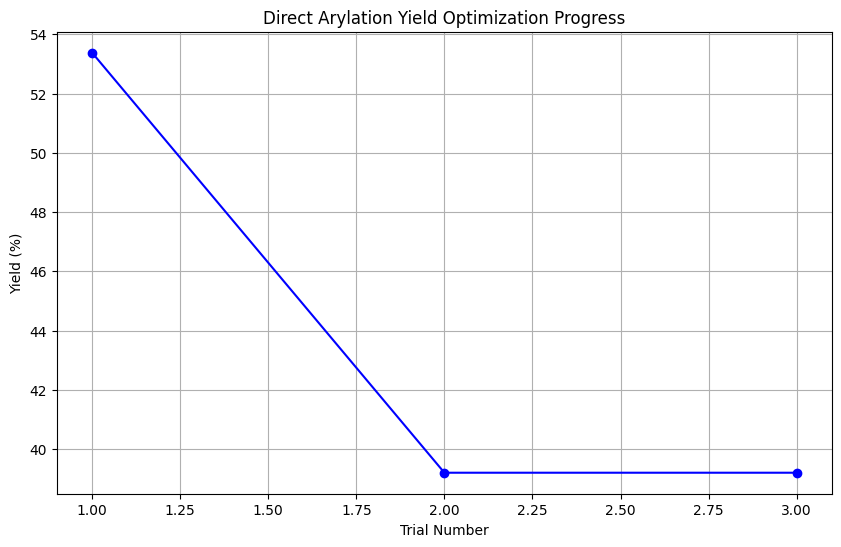

In [21]:
import matplotlib.pyplot as plt

# Create x-axis (trial numbers)
trials = range(1, len(mean_results) + 1)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(trials, mean_results, marker='o', linestyle='-', color='b')
plt.xlabel('Trial Number')
plt.ylabel('Yield (%)')
plt.title('Direct Arylation Yield Optimization Progress')
plt.grid(True)

# Show plot
plt.show()

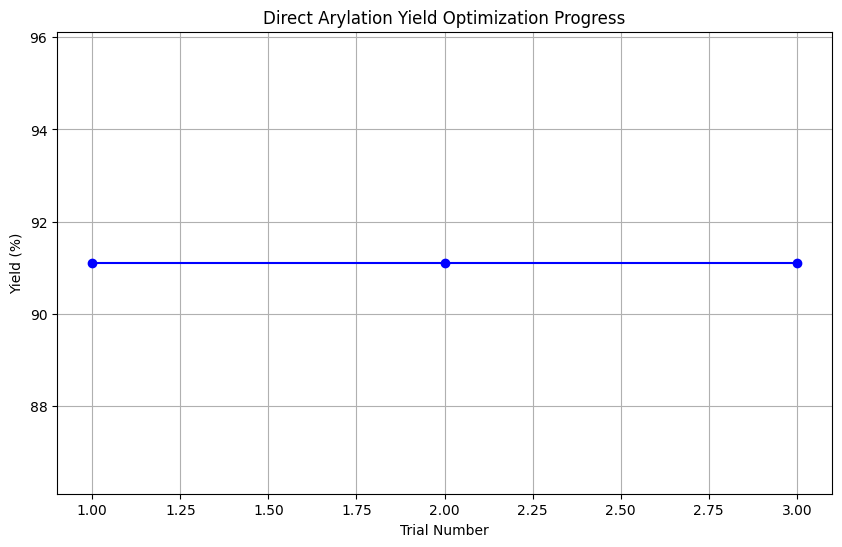

In [22]:
import matplotlib.pyplot as plt

# Create x-axis (trial numbers)
trials = range(1, len(max_results) + 1)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(trials, max_results, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Trial Number')
plt.ylabel('Yield (%)')
plt.title('Direct Arylation Yield Optimization Progress')
plt.grid(True)

# Show plot
plt.show()